In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from pyramid.arima import auto_arima

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

/Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_eth = pd.read_json('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1438992000&end=9999999999&period=300')
df_eth.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,1.75,2015-08-08 06:15:00,1.75,1.61,1.65,45.000000,75.150000,1.67
1,1.85,2015-08-08 06:20:00,1.85,1.85,1.85,7.880354,14.578655,1.85
2,1.85,2015-08-08 06:25:00,1.85,1.85,1.85,0.160000,0.296000,1.85
3,1.85,2015-08-08 06:30:00,1.85,1.85,1.85,0.089794,0.166119,1.85
4,1.85,2015-08-08 06:35:00,1.85,1.85,1.85,0.000000,0.000000,1.85


In [3]:
df_eth.set_index('date', inplace=True)
df_eth.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08 06:15:00,1.75,1.75,1.61,1.65,45.000000,75.150000,1.67
2015-08-08 06:20:00,1.85,1.85,1.85,1.85,7.880354,14.578655,1.85
2015-08-08 06:25:00,1.85,1.85,1.85,1.85,0.160000,0.296000,1.85
2015-08-08 06:30:00,1.85,1.85,1.85,1.85,0.089794,0.166119,1.85
2015-08-08 06:35:00,1.85,1.85,1.85,1.85,0.000000,0.000000,1.85


In [4]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 317646 entries, 2015-08-08 06:15:00 to 2018-08-15 04:40:00
Data columns (total 7 columns):
close              317646 non-null float64
high               317646 non-null float64
low                317646 non-null float64
open               317646 non-null float64
quoteVolume        317646 non-null float64
volume             317646 non-null float64
weightedAverage    317646 non-null float64
dtypes: float64(7)
memory usage: 19.4 MB


In [5]:
df_eth_close = df_eth[['close']]
df_eth_close.head()

,close
date,
2015-08-08 06:15:00,1.75
2015-08-08 06:20:00,1.85
2015-08-08 06:25:00,1.85
2015-08-08 06:30:00,1.85
2015-08-08 06:35:00,1.85


In [6]:
mms = MinMaxScaler(feature_range=(-1,1))
eth_norm = pd.DataFrame(mms.fit_transform(df_eth_close), columns=df_eth_close.columns)

In [7]:
eth_norm.head()

,close
0,-0.997547
1,-0.997406
2,-0.997406
3,-0.997406
4,-0.997406


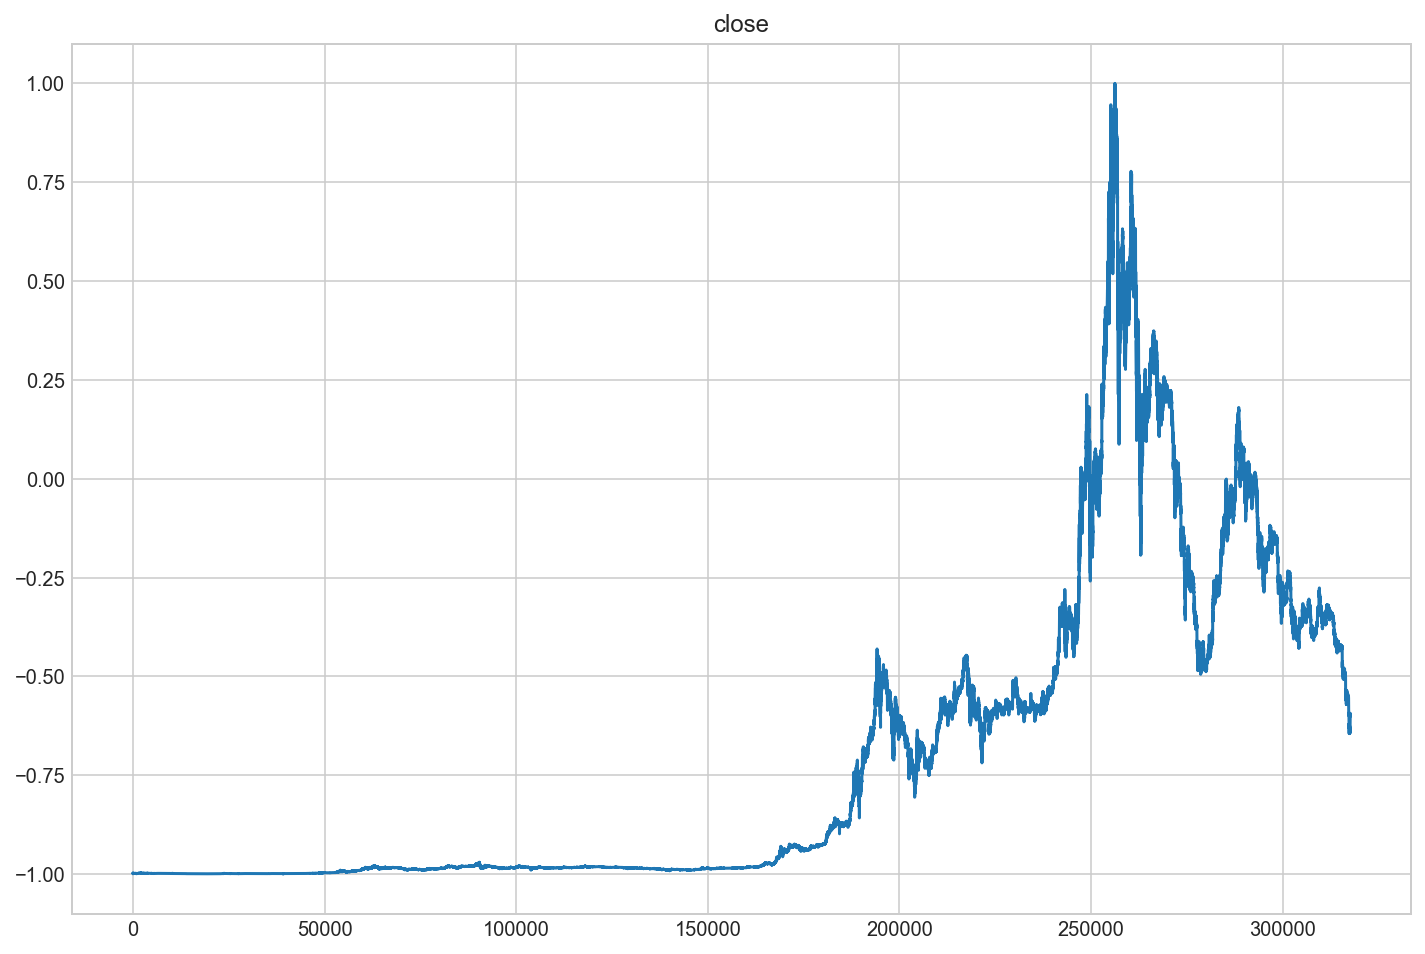

In [9]:
for c in eth_norm.columns:
    eth_norm[c].plot(figsize=(12,8))
    plt.title(c)
    plt.show()

In [10]:
eth_norm.shape

(317646, 1)

In [11]:
train_size = int(eth_norm.shape[0] * 0.8)
test_size = eth_norm.shape[0] - train_size
print eth_norm.shape[0], train_size, test_size

train, test = eth_norm.iloc[0:train_size,:], eth_norm.iloc[train_size:,:]

317646 254116 63530


In [12]:
def create_XY(df):
    Y = df.iloc[1:, :]
    X = df.iloc[:-1, :]
    return X.values, Y.values

In [13]:
Xtrain, Ytrain = create_XY(train)
Xtest, Ytest = create_XY(test)

In [14]:
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

((254115, 1), (254115, 1))
((63529, 1), (63529, 1))


In [15]:
# reshape input to be [samples, time steps, features]
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

In [16]:
# create and fit the LSTM network
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(32, batch_input_shape=(1, 1, Xtrain.shape[2]), stateful=True))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 32)                   4352      
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [17]:
for i in range(20):
    if (i % 5) == 0:
        print 'ITER:', i
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

ITER: 0
Epoch 1/1
254115/254115 [==============================] - 618s 2ms/step - loss: 8.9492e-05
ITER: 5
Epoch 1/1
254115/254115 [==============================] - 643s 3ms/step - loss: 9.8274e-05
ITER: 10
Epoch 1/1
254115/254115 [==============================] - 677s 3ms/step - loss: 7.3937e-05
ITER: 15
Epoch 1/1
254115/254115 [==============================] - 700s 3ms/step - loss: 8.4064e-05


In [18]:
def plot_all(model, Xtrain, Xtest, Ytest, stocks, stocks_names):
    train_hat = model.predict(Xtrain, batch_size=1)
    model.reset_states()
    test_hat = model.predict(Xtest, batch_size=1)
    model.reset_states()
    
    train_plot = np.empty_like(stocks.values)
    train_plot[:, :] = np.nan
    train_plot[1:Xtrain.shape[0]+1, :] = train_hat
    
    test_plot = np.empty_like(stocks.values)
    test_plot[:, :] = np.nan
    test_plot[-Xtest.shape[0]:, :] = test_hat
    
    fig, axarr = plt.subplots(Ytest.shape[1], 1, figsize=(18,12), squeeze=False)
    
    axarr = axarr.flatten()
    
    for i in range(Ytest.shape[1]):
        axarr[i].plot(stocks.iloc[:,i], color='grey', alpha=0.7)
        axarr[i].plot(train_plot[:,i], color='blue')
        axarr[i].plot(test_plot[:,i], color='orange')
        test_r2 = r2_score(Ytest[:,i], test_hat[:,i])
        axarr[i].set_title(stocks_names[i]+' test R2: '+str(test_r2))
        
    plt.show()

In [19]:
print Ytest.shape[1]

1


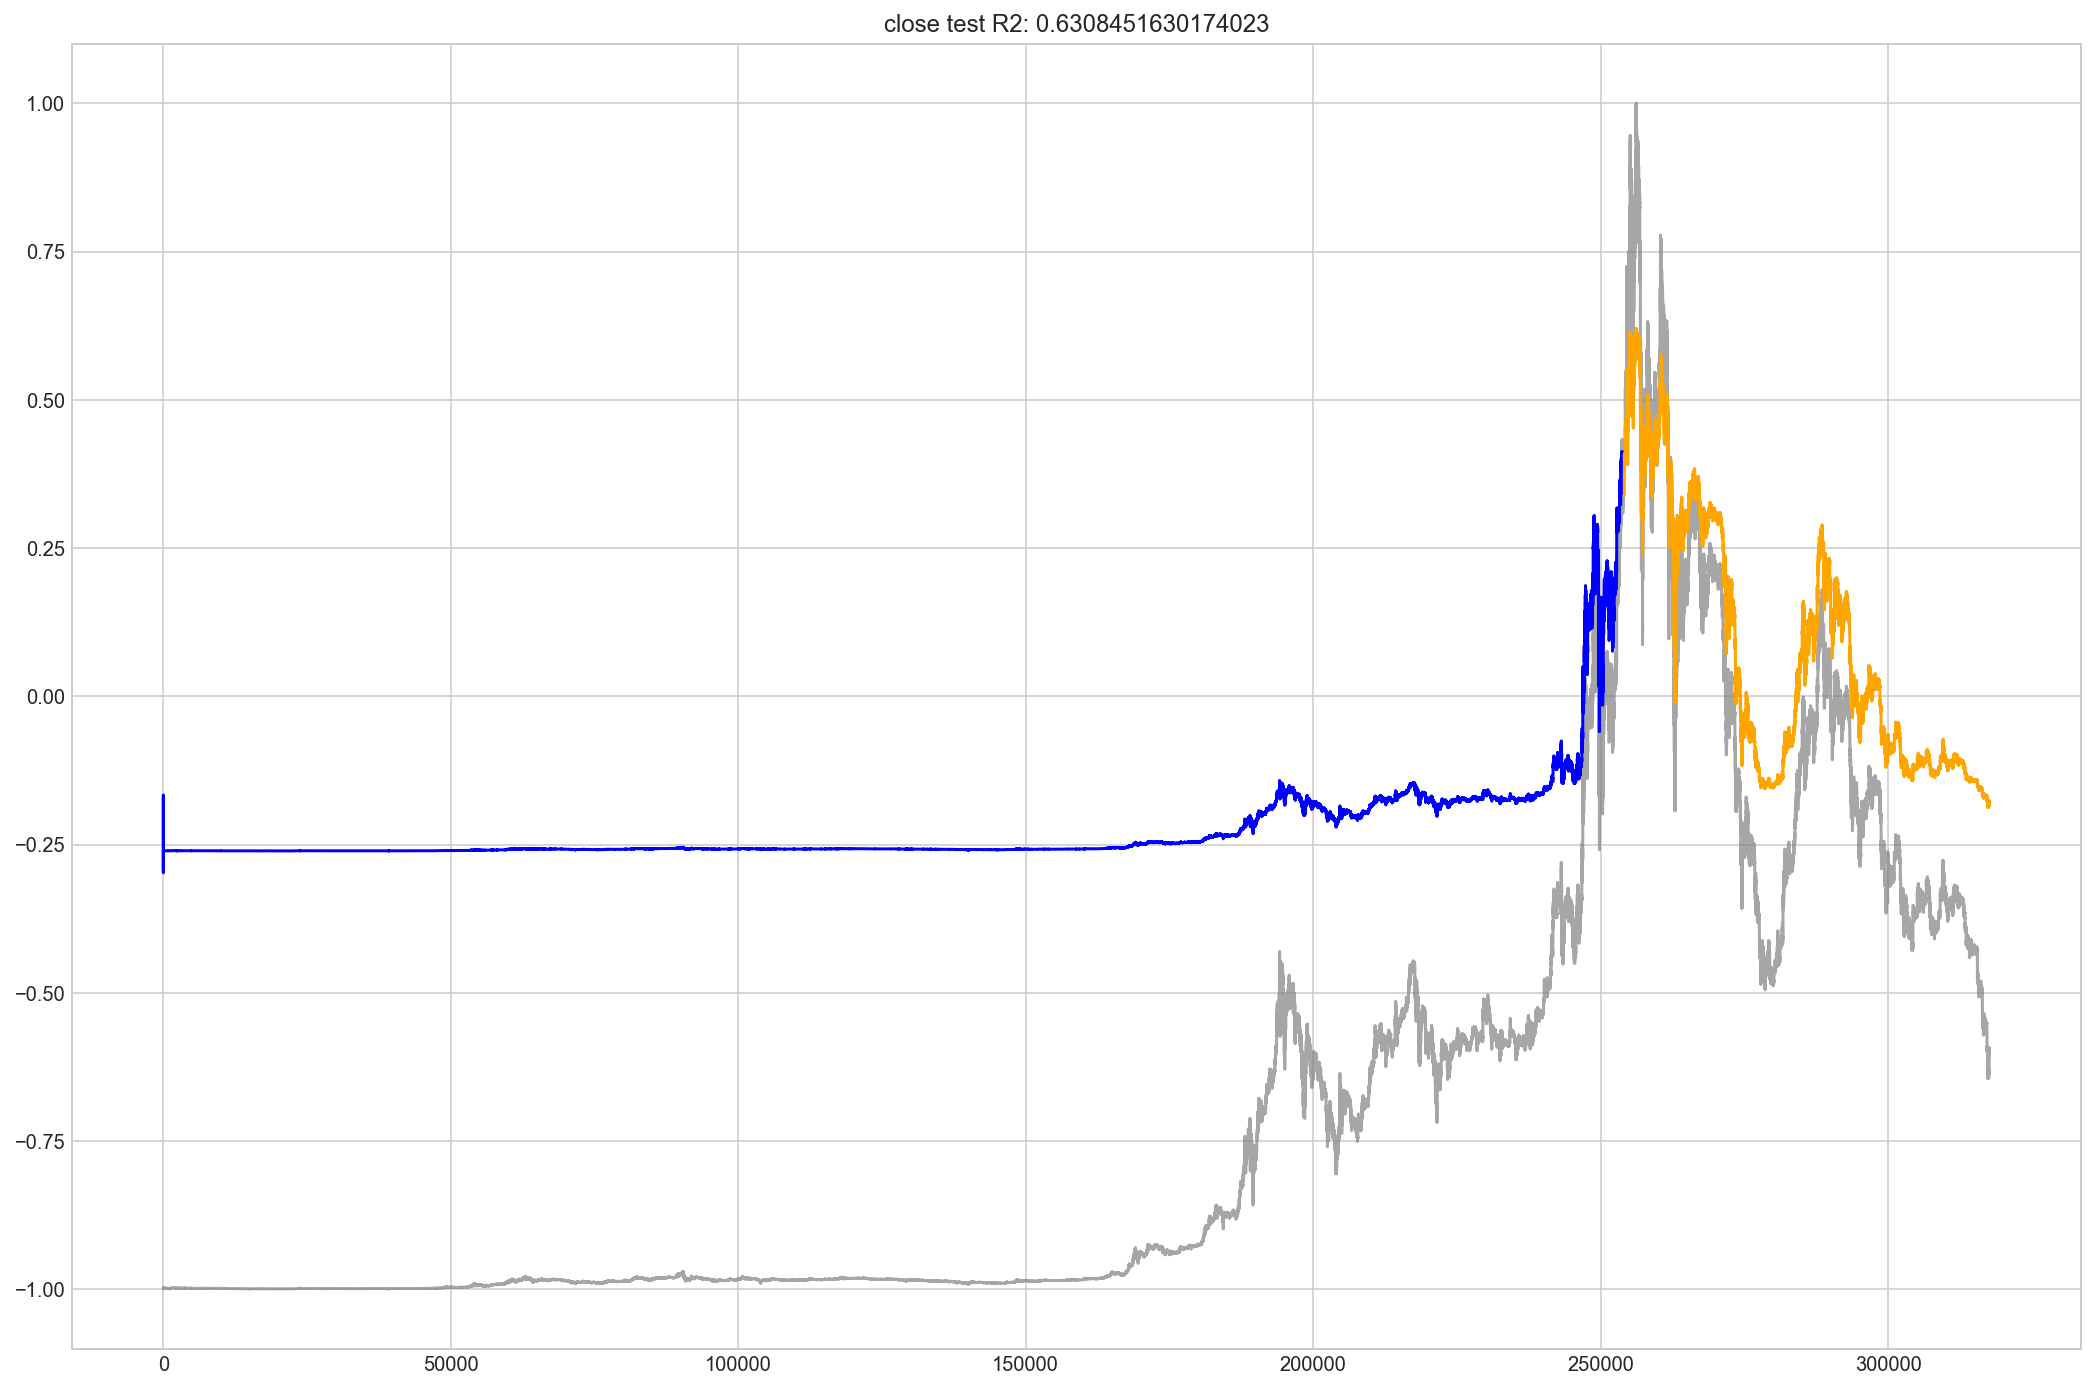

In [20]:
plot_all(model, Xtrain, Xtest, Ytest, eth_norm, eth_norm.columns)